# Brain Tumor Detection
Description
This dataset was originally created by Yousef Ghanem. To see the current project, which may have been updated since this version, please go here: https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f.

This dataset is part of RF100, an Intel-sponsored initiative to create a new object detection benchmark for model generalizability.

Access the RF100 Github repo: https://github.com/roboflow-ai/roboflow-100-benchmark

## Imports

In [1]:
from tqdm.notebook import tqdm

from dotenv import load_dotenv
load_dotenv()

import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
tf.config.list_physical_devices('GPU'), tf.__version__

2025-02-14 10:46:26.466794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739529986.477967   39143 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739529986.481476   39143 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-14 10:46:26.494239: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.18.0')

In [2]:
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths Setup

In [3]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/brain-tumor-2/train/


In [4]:
cfg.DATASET_DIRS

{'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}

In [5]:
from cProfile import label
from pathlib import Path

DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)

TRAIN_IMAGE_DIR = TRAIN_DIR / 'images'
TRAIN_LABELS_DIR = TRAIN_DIR / 'labels'

VALID_IMAGE_DIR = VALIDATION_DIR / 'images'
VALID_LABELS_DIR = VALIDATION_DIR / 'labels'

TEST_IMAGE = TEST_DIR / 'images'
TEST_LABELS = TEST_DIR / 'labels'

IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE

CLASS_NAME = [
    'label0',
    'label1',
    'label2'
]
class_map = {k: v for k, v in enumerate(CLASS_NAME)}
class_map[0]

'label0'

## Dataset Download from Roboflow

In [6]:
if not TRAIN_DIR.exists():
    from roboflow import Roboflow
    rf = Roboflow()
    project = rf.workspace("roboflow-100").project("brain-tumor-m2pbp")
    version = project.version(2)
    dataset = version.download("yolov8")
                

## Load images from directory

In [7]:
from utils.prepare_dataset import PrepareDataset
prepare_train_dataset = PrepareDataset(image_dir=TRAIN_IMAGE_DIR, 
                                    label_dir=TRAIN_LABELS_DIR,
                                    dst_img_size=(IMG_SIZE, IMG_SIZE))

train_images, (train_class_ids, train_bboxes)  = prepare_train_dataset.get_dataset()

  0%|          | 0/6930 [00:00<?, ?it/s]

In [8]:
len(train_images), len(train_class_ids), len(train_bboxes)

(15296, 15296, 15296)

In [9]:
def convert_coordinates_for_plot(image, bbox):
  x_center, y_center, width, height = bbox
  img_height, img_width = image.shape[:2]
  xmin = int(max(0, (x_center - width / 2) * img_width))  # Clip to 0
  ymin = int(max(0, (y_center - height / 2) * img_height)) # Clip to 0
  xmax = int(min(img_width, (x_center + width / 2) * img_width)) # Clip to image width
  ymax = int(min(img_height, (y_center + height / 2) * img_height))# Clip to image height


  return np.array([xmin, ymin, xmax, ymax], dtype=np.int32)#.reshape(1, 4)


In [10]:
import random

def plot_random_images_bbox(image_paths, class_ids, bboxes, NUM_IMAGES_DISPLAY=9):
  fig = plt.figure(figsize=(8, 8))
  random_samples = random.sample(range(len(image_paths)), NUM_IMAGES_DISPLAY)

  for i, idx in enumerate(random_samples):
    ax = fig.add_subplot(3, 3, i+1)
    image_path = image_paths[idx]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # print(train_bboxes[i])
    xmin, ymin, xmax, ymax = convert_coordinates_for_plot(image, bboxes[idx])
    ax.set_title(class_map[class_ids[idx]])
    ax.axis('off')
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)
    plt.imshow(image)

  plt.show()

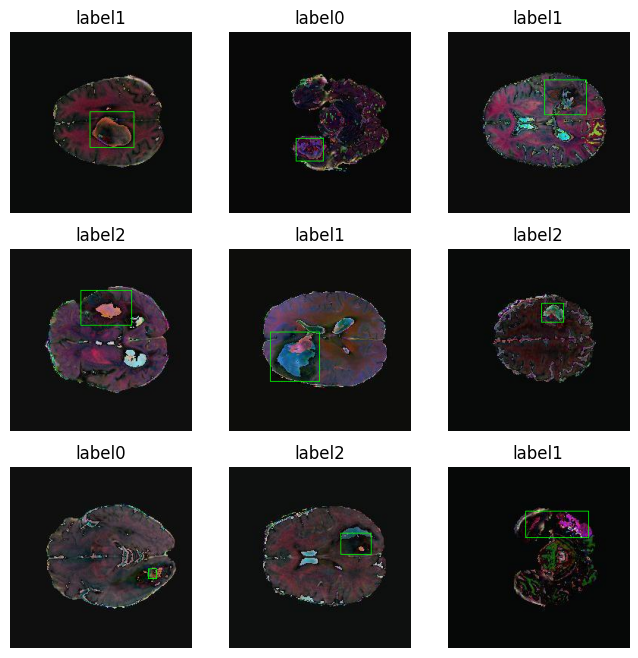

In [11]:
plot_random_images_bbox(train_images, train_class_ids, train_bboxes)

## Analyzing Imbalance 

In [12]:
(classes, count) = np.unique(train_class_ids, return_counts=True)
classes, count

(array([0, 1, 2], dtype=int8), array([4338, 6836, 4122]))

In [13]:
np.unique(train_class_ids, return_counts=True)[0]

array([0, 1, 2], dtype=int8)

In [14]:
class_labels = np.array([0, 1, 2])
class_counts = np.array([4338, 6836, 4122])

total_samples = sum(class_counts)
class_proportions = class_counts / total_samples

print("Class Proportions:", class_proportions)

Class Proportions: [0.28360356 0.44691423 0.26948222]


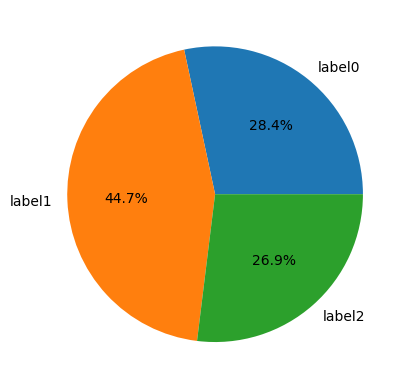

In [15]:
plt.pie(x=count, labels=class_map.values(),autopct='%1.1f%%')
plt.show()

In [16]:
def seperate_class_with_datasets(train_images, train_class_ids, train_bboxes, class_id):
  idx = np.where(train_class_ids == class_id)[0]
  return (np.array(train_images)[idx], train_class_ids[idx], train_bboxes[idx])

In [17]:
class0_datasets = seperate_class_with_datasets(train_images, train_class_ids, train_bboxes, 0)
class1_datasets = seperate_class_with_datasets(train_images, train_class_ids, train_bboxes, 1)
class2_datasets = seperate_class_with_datasets(train_images, train_class_ids, train_bboxes, 2)
len(class0_datasets[0]), len(class1_datasets[0]), len(class2_datasets[0])

(4338, 6836, 4122)

In [18]:
train_images, train_class_ids, train_bboxes=class0_datasets
train_class_ids

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [19]:
class0_datasets[1]

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [20]:
down_samp_value = np.min([class0_datasets[0].shape[0], class1_datasets[0].shape[0], class2_datasets[0].shape[0]])
down_samp_value

np.int64(4122)

In [21]:
len(class0_datasets[1][:down_samp_value])

4122

In [22]:
down_sampled_imgs0, down_sampled_classid0, downsampled_bboxes0 = class0_datasets[0][:down_samp_value], class0_datasets[1][:down_samp_value], class0_datasets[2][:down_samp_value]
downsampled_imgs1, down_sampled_classid1, down_sampled_bboxes1 = class1_datasets[0][:down_samp_value], class1_datasets[1][:down_samp_value], class1_datasets[2][:down_samp_value]
down_sampled_imgs2, down_sampled_classid2, down_sampled_bboxes2 = class2_datasets[0][:down_samp_value], class2_datasets[1][:down_samp_value], class2_datasets[2][:down_samp_value]
len(down_sampled_imgs0), len(down_sampled_classid1), len(down_sampled_bboxes2)

(4122, 4122, 4122)

In [23]:
down_sample_images = np.concat([down_sampled_imgs0, downsampled_imgs1, down_sampled_imgs2]) 
down_sample_classids = np.concat([down_sampled_classid0, down_sampled_classid1, down_sampled_classid2]) 
down_sample_bboxes = np.concat([downsampled_bboxes0, down_sampled_bboxes1, down_sampled_bboxes2]) 
len(down_sample_images), len(down_sample_classids), len(down_sample_bboxes)

(12366, 12366, 12366)

In [24]:
(classes, count) = np.unique(down_sample_classids, return_counts=True)
classes, count

(array([0, 1, 2], dtype=int8), array([4122, 4122, 4122]))

In [27]:
rebal_train_images, rebal_train_class_ids, rebal_train_bboxes = prepare_train_dataset.rebalance_by_down_sampling_datasets()
len(train_images), len(train_class_ids), len(train_bboxes)

[INFO] Unique class ids: [0 1 2], value counts: [4338 6836 4122]


(12366, 12366, 12366)

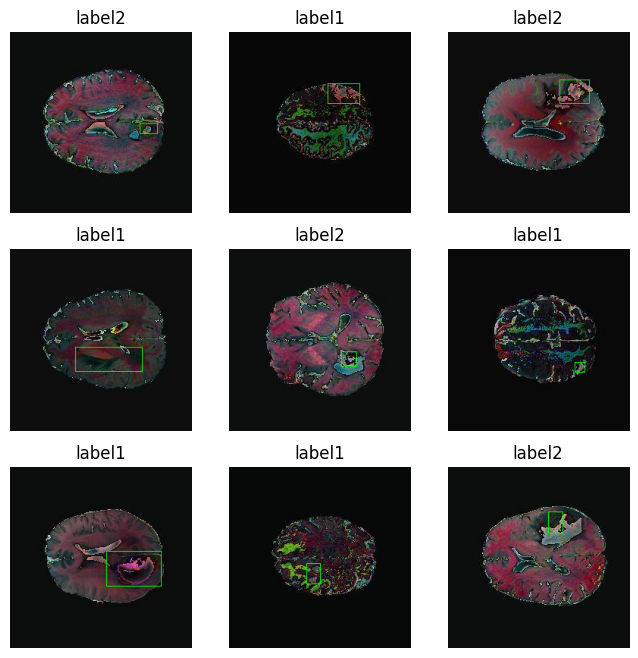

In [28]:
plot_random_images_bbox(rebal_train_images, rebal_train_class_ids, rebal_train_bboxes)